In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, smart_resize, ImageDataGenerator

from tensorflow.keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)
from skimage import io

# For reproducibility
np.random.seed(27)

In [3]:
# Convert webp files to jpg

def convert_webp_jpg(file_path):
    """Converting webp files to jpg.  JPG are well suited for CNNs due to size and quality""" 
    raw_dataset = os.listdir(file_path)
    for file in raw_dataset:
        if file.lower().endswith('.webp'):
            path = file_path + file
            with Image.open(path) as pic:
                pic = pic.convert('RGB')
                jpg = file.rsplit('.', 1)[0] + '.jpg'
                new_path = file_path + jpg
                pic.save(new_path, 'JPEG')

In [4]:
convert_webp_jpg('../data/01_raw/clean/')

In [5]:
convert_webp_jpg('../data/01_raw/dirty/')

In [3]:
train, test = image_dataset_from_directory(
    '../data/classified/',
    image_size=(128, 128),
    batch_size=4,
    label_mode='binary',
    seed=42,
    validation_split=0.1,
    subset='both'
)

Found 424 files belonging to 2 classes.
Using 382 files for training.
Using 42 files for validation.


In [4]:
# model for image classification
model = Sequential()
model.add(Input((128, 128, 3)))
model.add(Rescaling(1./255))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

#model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 128)               32514176  
                                                        

In [ ]:
# fit model
model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
96/96 [==============================] - 8s 79ms/step - loss: 0.9740 - accuracy: 0.7801 - val_loss: 0.5557 - val_accuracy: 0.8333
Epoch 2/10
96/96 [==============================] - 8s 78ms/step - loss: 0.6738 - accuracy: 0.8194 - val_loss: 0.6891 - val_accuracy: 0.8333
Epoch 3/10
96/96 [==============================] - 8s 78ms/step - loss: 0.5542 - accuracy: 0.8220 - val_loss: 0.5778 - val_accuracy: 0.8333
Epoch 4/10
96/96 [==============================] - 7s 77ms/step - loss: 0.5914 - accuracy: 0.8351 - val_loss: 0.5270 - val_accuracy: 0.8333
Epoch 5/10
96/96 [==============================] - 7s 77ms/step - loss: 0.5120 - accuracy: 0.8377 - val_loss: 0.5449 - val_accuracy: 0.8333
Epoch 6/10
14/96 [===>..........................] - ETA: 6s - loss: 0.4275 - accuracy: 0.8214

Clearly the model's performance is plateauing with the validation set being only 42 files and the dataset heavily imbalanced.

In [74]:
preds = np.round(model.predict(test), 2)

3/3 [==============================] - 0s 11ms/step


In [75]:
# check for a single image
tester = load_img('../data/02_classified/clean/47681173_2008763662504219_1873423245131120640_n.jpg')
test_image = img_to_array(tester)
test_image.shape

(540, 720, 3)

In [76]:
# resize image
test_image = smart_resize(test_image, (128, 128))
test_image.shape

(128, 128, 3)

In [77]:
# need to add a dimension as model is expecting a 4th dimension for the place in the batch
test_image = np.expand_dims(test_image, axis=0)
test_image.shape

(1, 128, 128, 3)

In [78]:
model.predict(test_image)

1/1 [==============================] - 0s 93ms/step


array([[0.8204604]], dtype=float32)

In [ ]:
test.class_names

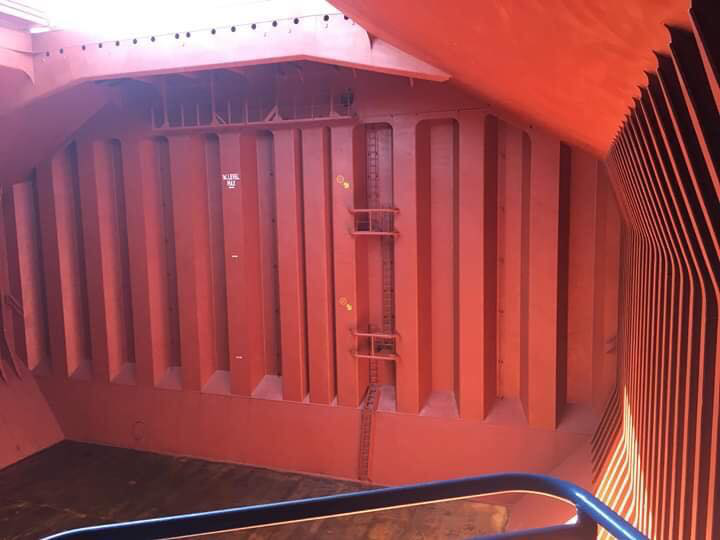

In [64]:
tester

# Confusion Matrix

https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html  

ConfusionMatrixDisplay.from_estimator(logr, X_test_ss, y_test, cmap='Blues');

In [ ]:
# data augmentation
datagen = ImageDataGenerator(
    brightness_range=(0.5, 1.5),
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.1,
    fill_mode='constant'
)

array([[[252, 247, 254],
        [253, 248, 255],
        [255, 250, 255],
        ...,
        [ 32,  13,  17],
        [ 32,  13,  17],
        [ 32,  13,  17]],

       [[255, 251, 255],
        [254, 249, 255],
        [252, 247, 254],
        ...,
        [ 32,  13,  17],
        [ 32,  13,  17],
        [ 32,  13,  17]],

       [[240, 235, 241],
        [244, 239, 245],
        [251, 246, 252],
        ...,
        [ 32,  13,  17],
        [ 32,  13,  17],
        [ 32,  13,  17]],

       ...,

       [[ 67,  39,  36],
        [ 69,  41,  38],
        [ 65,  37,  34],
        ...,
        [106,  52,  52],
        [106,  51,  48],
        [106,  49,  42]],

       [[ 72,  44,  41],
        [ 72,  44,  41],
        [ 66,  38,  35],
        ...,
        [106,  52,  52],
        [106,  51,  48],
        [106,  49,  42]],

       [[ 74,  46,  43],
        [ 72,  44,  41],
        [ 66,  38,  35],
        ...,
        [106,  52,  52],
        [106,  51,  48],
        [106,  49,  42]]], dtype=uint8)
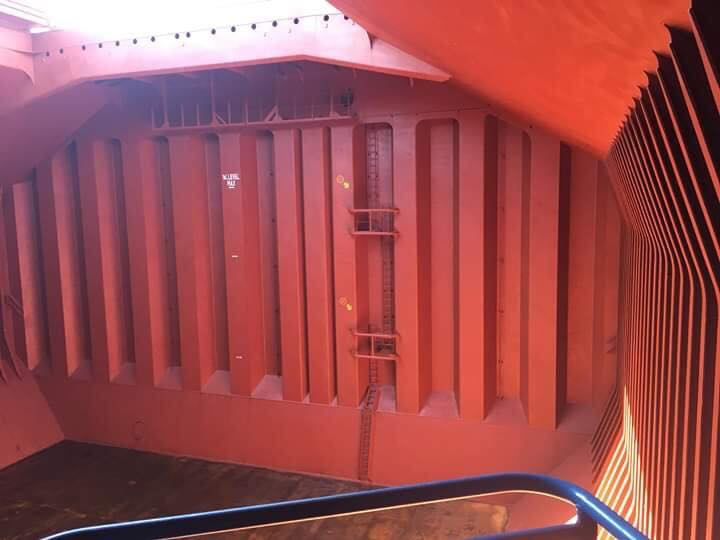

In [ ]:
x = io.imread('/content/47681173_2008763662504219_1873423245131120640_n.jpg')
x

In [ ]:
x = x.reshape((1,) + x.shape)
x.shape

(1, 540, 720, 3)

In [ ]:
# https://www.youtube.com/watch?v=ccdssX4rIh8

i = 0
for batch in datagen.flow(x, batch_size=4,
                          save_to_dir='preview',
                          save_prefix='cargo',
                          save_format='jpeg'):
  i += 1
  if i > 20:
    break

In [ ]:
# creating training data
train_generator = datagen.flow_from_directory(
    'cargo holds',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

FileNotFoundError: [Errno 2] No such file or directory: 'cargo holds'

In [ ]:
val_generator = datagen.flow_from_directory(
    'cargo holds',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 11 images belonging to 2 classes.


In [ ]:
# fit model
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.